In [ ]:
#| hide
!pip install -Uqq nixtla

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 1.9 MB/s eta 0:00:00


In [ ]:
#| hide
from nixtla.utils import in_colab

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
#| hide
IN_COLAB = in_colab()

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv

# Fine-tuning

Fine-tuning is a powerful process for utilizing TimeGPT more effectively. Foundation models such as TimeGPT are pre-trained on vast amounts of data, capturing wide-ranging features and patterns. These models can then be specialized for specific contexts or domains. With fine-tuning, the model's parameters are refined to forecast a new task, allowing it to tailor its vast pre-existing knowledge towards the requirements of the new data. Fine-tuning thus serves as a crucial bridge, linking TimeGPT's broad capabilities to your tasks specificities.

Concretely, the process of fine-tuning consists of performing a certain number of training iterations on your input data minimizing the forecasting error. The forecasts will then be produced with the updated model. To control the number of iterations, use the `finetune_steps` argument of the `forecast` method.

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/06_finetuning')

## 1. Import packages
First, we import the required packages and initialize the Nixtla client

In [ ]:
import pandas as pd
from nixtla import NixtlaClient
from utilsforecast.losses import mae, mse
from utilsforecast.evaluation import evaluate

In [ ]:
from google.colab import userdata

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = userdata.get('NIXTLA_API_KEY')
)

> 👍 Use an Azure AI endpoint
>
> To use an Azure AI endpoint, remember to set also the `base_url` argument:
>
> `nixtla_client = NixtlaClient(base_url="you azure ai endpoint", api_key="your api_key")`

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## 2. Load data

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df.head()

,timestamp,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## 3. Fine-tuning

Here, `finetune_steps=10` means the model will go through 10 iterations of training on your time series data.

In [ ]:
timegpt_fcst_finetune_df = nixtla_client.forecast(
    df=df, h=12, finetune_steps=10,
    time_col='timestamp', target_col='value',
)

> 📘 Available models in Azure AI
>
> If you are using an Azure AI endpoint, please be sure to set `model="azureai"`:
>
> `nixtla_client.forecast(..., model="azureai")`
>
> For the public API, we support two models: `timegpt-1` and `timegpt-1-long-horizon`.
>
> By default, `timegpt-1` is used. Please see [this tutorial](https://docs.nixtla.io/docs/tutorials-long_horizon_forecasting) on how and when to use `timegpt-1-long-horizon`.

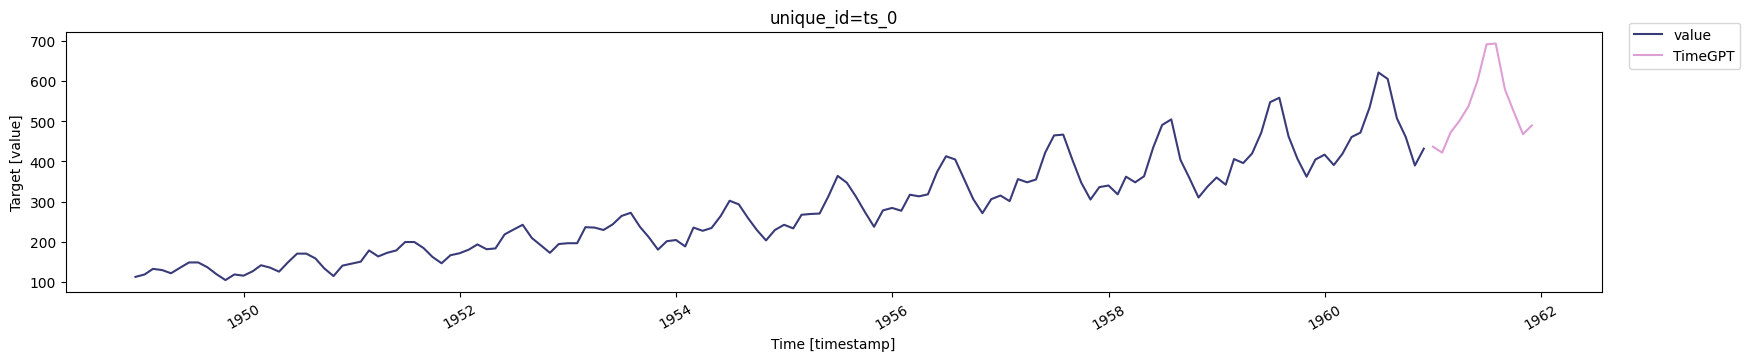

In [ ]:
nixtla_client.plot(
    df, timegpt_fcst_finetune_df,
    time_col='timestamp', target_col='value',
)

### 3.1 Control the level of fine-tuning with `finetune_depth`
It is also possible to control the depth of fine-tuning with the `finetune_depth` parameter.

`finetune_depth` takes values among `[1, 2, 3, 4, 5]`. By default, it is set to 1, which means that a small set of the model's parameters are being adjusted, whereas a value of 5 fine-tunes the maximum amount of parameters. Increasing `finetune_depth` also increases the time to generate predictions.

Let's run a small experiment to see how `finetune_depth` impacts the performance.

In [ ]:
train = df[:-24]
test = df[-24:]

In [ ]:
depths = [1, 2, 3, 4, 5]

test = test.copy()

for depth in depths:
    preds_df = nixtla_client.forecast(
    df=train,
    h=24,
    finetune_steps=5,
    finetune_depth=depth,
    time_col='timestamp',
    target_col='value')

    preds = preds_df['TimeGPT'].values

    test.loc[:,f'TimeGPT_depth{depth}'] = preds

In [ ]:
test['unique_id'] = 0

evaluation = evaluate(test, metrics=[mae, mse], time_col="timestamp", target_col="value")
evaluation

,unique_id,metric,TimeGPT_depth1,TimeGPT_depth2,TimeGPT_depth3,TimeGPT_depth4,TimeGPT_depth5
0,0,mae,22.805146,17.942616,21.320125,24.860270,29.013218
1,0,mse,683.303778,462.740144,678.182747,997.341835,1137.008089


As you can see, increasing the depth of fine-tuning can improve the performance of the model, but it can make it worse too due to overfitting.

Thus, keep in mind that fine-tuning can be a bit of trial and error. You might need to adjust the number of `finetune_steps` and the level of `finetune_depth` based on your specific needs and the complexity of your data. Usually, a higher `finetune_depth` works better for large datasets. In this specific tutorial, since we were forecasting a single series with a very short dataset, increasing the depth led to overfitting.

It's recommended to monitor the model's performance during fine-tuning and adjust as needed. Be aware that more `finetune_steps` and a larger value of `finetune_depth` may lead to longer training times and could potentially lead to overfitting if not managed properly.

Remember, fine-tuning is a powerful feature, but it should be used thoughtfully and carefully.

For a detailed guide on using a specific loss function for fine-tuning, check out the [Fine-tuning with a specific loss function](https://docs.nixtla.io/docs/tutorials-fine_tuning_with_a_specific_loss_function) tutorial.